# Setup and Data Loading

In [4]:
import pandas as pd 
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime 
import warnings 
warnings.filterwarnings('ignore')

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
# Feature Selection 
from sklearn.ensemble import RandomForestRegressor 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Date: 2025-11-08 22:43


In [8]:
# Filepaths and Directories
# Input Paths
PROCESSED_DATA_PATH = "../data/processed/"
IO_DATA_PATH = "../data/processed_io_data/"

# Output paths
OUTPUT_PATH = "./task2_45/"
FEATURES_OUTPUT = "./task2_45/features/"
FIGURES_PATH = "./task2_45/figures/"

import os
for path in [OUTPUT_PATH, FEATURES_OUTPUT, FIGURES_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"✓ Input:  {PROCESSED_DATA_PATH}")
print(f"✓ Output: {OUTPUT_PATH}")
print(f"✓ Features: {FEATURES_OUTPUT}")
print(f"✓ Figures: {FIGURES_PATH}")

✓ Input:  ../data/processed/
✓ Output: ./task2_45/
✓ Features: ./task2_45/features/
✓ Figures: ./task2_45/figures/


In [ ]:
# Load Master Dataset 
# Load data
master_df = pd.read_csv(PROCESSED_DATA_PATH + "master_dataset.csv")

# Convert date
master_df['date'] = pd.to_datetime(master_df['date'])

# Sort by sector and date
master_df = master_df.sort_values(['sector_name', 'date']).reset_index(drop=True)

print(f"\n Master dataset loaded:")
print(f"  Rows: {len(master_df):,}")
print(f"  Columns: {len(master_df.columns)}")
print(f"  Sectors: {master_df['sector_name'].nunique()}")
print(f"  Date range: {master_df['date'].min()} to {master_df['date'].max()}")


✓ Master dataset loaded:
  Rows: 3,476
  Columns: 93
  Sectors: 22
  Date range: 2012-04-01 00:00:00 to 2024-12-01 00:00:00


In [10]:
# Check key variables
print(f"\n[Checking key variables...]")
key_vars = ['iip_yoy_growth', 'CRUDE_PETRO', 'WHEAT_US_HRW', 'RICE_05', 
            'ONI', 'backward_linkage', 'forward_linkage']

for var in key_vars:
    if var in master_df.columns:
        missing = master_df[var].isnull().sum()
        print(f"   {var}: {missing:,} missing ({missing/len(master_df)*100:.1f}%)")
    else:
        print(f"   {var}: NOT FOUND")


[Checking key variables...]
   iip_yoy_growth: 286 missing (8.2%)
   CRUDE_PETRO: 0 missing (0.0%)
   WHEAT_US_HRW: 0 missing (0.0%)
   RICE_05: 0 missing (0.0%)
   ONI: 2,068 missing (59.5%)
   backward_linkage: 0 missing (0.0%)
   forward_linkage: 0 missing (0.0%)


In [13]:
# ============================================================================
# DIAGNOSTIC: CHECK MASTER_DF FEATURE COLUMNS
# ============================================================================

print("="*70)
print("MASTER_DF FEATURE AUDIT")
print("="*70)

# 1. Check lagged commodity features
print("\n[1] LAGGED COMMODITY PRICE FEATURES:")
lag_patterns = ['_lag_1m', '_lag_3m', '_lag_6m', '_lag_12m']
commodities = ['CRUDE_PETRO', 'WHEAT_US_HRW', 'RICE_05', 'COPPER', 'ALUMINUM']

for commodity in commodities:
    print(f"\n  {commodity}:")
    for lag in lag_patterns:
        col_name = f"{commodity}{lag}"
        if col_name in master_df.columns:
            non_null = master_df[col_name].notna().sum()
            print(f"    ✓ {col_name:30s}: {non_null:,} non-null")
        else:
            print(f"    ✗ {col_name:30s}: MISSING")

# 2. Check volatility features
print("\n[2] VOLATILITY FEATURES:")
vol_features = [col for col in master_df.columns if 'volatility' in col]
print(f"  Found {len(vol_features)} volatility features:")
for feat in vol_features[:10]:  # Show first 10
    print(f"    • {feat}")

# 3. Check shock indicators
print("\n[3] SHOCK INDICATOR FEATURES:")
shock_features = [col for col in master_df.columns if 'shock' in col]
print(f"  Found {len(shock_features)} shock features:")
for feat in shock_features[:10]:
    print(f"    • {feat}")

# 4. Check exposure features
print("\n[4] EXPOSURE FEATURES:")
exposure_keywords = ['exposure', 'intensity', 'energy_', 'food_', 'metal_']
exposure_features = [col for col in master_df.columns 
                     if any(kw in col.lower() for kw in exposure_keywords)]
print(f"  Found {len(exposure_features)} exposure features:")
for feat in exposure_features:
    print(f"    • {feat}")

# 5. Check interaction features
print("\n[5] INTERACTION FEATURES:")
interaction_features = [col for col in master_df.columns if '_x_' in col]
print(f"  Found {len(interaction_features)} interaction features:")
for feat in interaction_features[:10]:
    print(f"    • {feat}")

# 6. Check temporal features
print("\n[6] TEMPORAL FEATURES:")
temporal_expected = ['year', 'month', 'quarter', 'month_sin', 'month_cos', 
                     'q1', 'q2', 'q3', 'q4', 'time_trend', 'financial_year']
print(f"  Checking expected temporal features:")
for feat in temporal_expected:
    if feat in master_df.columns:
        print(f"    ✓ {feat}")
    else:
        print(f"    ✗ {feat} - MISSING")

# 7. Total feature count
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Total columns: {len(master_df.columns)}")
print(f"  Lagged: {len([c for c in master_df.columns if '_lag_' in c])}")
print(f"  Volatility: {len(vol_features)}")
print(f"  Shocks: {len(shock_features)}")
print(f"  Exposure: {len(exposure_features)}")
print(f"  Interactions: {len(interaction_features)}")
print(f"  Temporal: {len([c for c in master_df.columns if c in temporal_expected])}")

# 8. Check for critical missing columns
print("\n[CRITICAL CHECKS:]")
critical_cols = ['iip_yoy_growth', 'CRUDE_PETRO', 'WHEAT_US_HRW', 'RICE_05',
                 'ONI', 'backward_linkage', 'forward_linkage', 'degree_centrality']

for col in critical_cols:
    if col in master_df.columns:
        missing = master_df[col].isnull().sum()
        print(f"  ✓ {col:30s}: {missing:,} missing ({missing/len(master_df)*100:.1f}%)")
    else:
        print(f"  ✗ {col:30s}: NOT FOUND - CRITICAL ISSUE!")

print("="*70)

MASTER_DF FEATURE AUDIT

[1] LAGGED COMMODITY PRICE FEATURES:

  CRUDE_PETRO:
    ✗ CRUDE_PETRO_lag_1m            : MISSING
    ✗ CRUDE_PETRO_lag_3m            : MISSING
    ✗ CRUDE_PETRO_lag_6m            : MISSING
    ✗ CRUDE_PETRO_lag_12m           : MISSING

  WHEAT_US_HRW:
    ✗ WHEAT_US_HRW_lag_1m           : MISSING
    ✗ WHEAT_US_HRW_lag_3m           : MISSING
    ✗ WHEAT_US_HRW_lag_6m           : MISSING
    ✗ WHEAT_US_HRW_lag_12m          : MISSING

  RICE_05:
    ✗ RICE_05_lag_1m                : MISSING
    ✗ RICE_05_lag_3m                : MISSING
    ✗ RICE_05_lag_6m                : MISSING
    ✗ RICE_05_lag_12m               : MISSING

  COPPER:
    ✗ COPPER_lag_1m                 : MISSING
    ✗ COPPER_lag_3m                 : MISSING
    ✗ COPPER_lag_6m                 : MISSING
    ✗ COPPER_lag_12m                : MISSING

  ALUMINUM:
    ✗ ALUMINUM_lag_1m               : MISSING
    ✗ ALUMINUM_lag_3m               : MISSING
    ✗ ALUMINUM_lag_6m               : MIS


# Feature Engineering

## **Creating Lagged Commodity Price Features**

In [16]:
# Lagged Commodity Price Features

# Commodities to lag: 
commodities = ['CRUDE_PETRO', 'WHEAT_US_HRW', 'RICE_05', 'COPPER', 'ALUMINUM']
# Lag periods (1, 3, 6, 12 months)
lags = [1, 3, 6, 12]
# Rolling windows (3,6,12)months
windows = [3,6,12]

feature_count = 0 
volatility_count = 0
for commodity in commodities:
    if commodity in master_df.columns:
        for window in windows:
            # Rolling volatility
            col_name = f"{commodity}_volatility_{window}m"
            master_df[col_name] = master_df.groupby('sector_name')[commodity]\
                .rolling(window=window, min_periods=2).std().reset_index(level=0, drop=True)
            volatility_count += 1
        
        # Print summary for first commodity
        if commodity == 'CRUDE_PETRO':
            print(f"  ✓ {commodity}:")
            for window in windows:
                col = f"{commodity}_volatility_{window}m"
                mean_vol = master_df[col].mean()
                print(f"    {window}m window: mean volatility = ${mean_vol:.2f}")
print(f"\n✓ Created {volatility_count} volatility features")
print(f"  ({len(commodities)} commodities × {len(windows)} windows)")

  ✓ CRUDE_PETRO:
    3m window: mean volatility = $4.03
    6m window: mean volatility = $5.95
    12m window: mean volatility = $8.39

✓ Created 15 volatility features
  (5 commodities × 3 windows)


In [17]:
# Calculating Price Changes [For Shock Indicators, later]
for commodity in commodities:
    if commodity in master_df.columns:
        # Month-over-month change
        master_df[f"{commodity}_mom_change"] = master_df.groupby('sector_name')[commodity]\
            .pct_change() * 100
        
        # Year-over-year change
        master_df[f"{commodity}_yoy_change"] = master_df.groupby('sector_name')[commodity]\
            .pct_change(periods=12) * 100

print("Created price change features (MoM, YoY)")

Created price change features (MoM, YoY)


## **Shock Indicator Features**

In [18]:
print("[Defining shocks as price changes > 2 standard deviations...]")
shock_count = 0

for commodity in commodities:
    if commodity in master_df.columns:
        # Calculate 2 standard deviations
        price_changes = master_df[f"{commodity}_mom_change"]
        mean_change = price_changes.mean()
        std_change = price_changes.std()
        threshold = 2 * std_change
        
        # Create shock indicators
        # Positive shock (price spike)
        master_df[f"{commodity}_shock_positive"] = (
            (master_df[f"{commodity}_mom_change"] > threshold).astype(int)
        )
        
        # Negative shock (price crash)
        master_df[f"{commodity}_shock_negative"] = (
            (master_df[f"{commodity}_mom_change"] < -threshold).astype(int)
        )
        
        # Any shock (absolute)
        master_df[f"{commodity}_shock_any"] = (
            (master_df[f"{commodity}_mom_change"].abs() > threshold).astype(int)
        )
        
        shock_count += 3
        
        # Count shocks
        n_positive = master_df[f"{commodity}_shock_positive"].sum()
        n_negative = master_df[f"{commodity}_shock_negative"].sum()
        
        print(f"   {commodity}:")
        print(f"    Threshold: ±{threshold:.1f}%")
        print(f"    Positive shocks: {n_positive:,} ({n_positive/len(master_df)*100:.1f}%)")
        print(f"    Negative shocks: {n_negative:,} ({n_negative/len(master_df)*100:.1f}%)")

print(f"\n✓ Created {shock_count} shock indicator features")
print(f"  ({len(commodities)} commodities × 3 types)")

[Defining shocks as price changes > 2 standard deviations...]
   CRUDE_PETRO:
    Threshold: ±19.4%
    Positive shocks: 88 (2.5%)
    Negative shocks: 88 (2.5%)
   WHEAT_US_HRW:
    Threshold: ±12.0%
    Positive shocks: 44 (1.3%)
    Negative shocks: 88 (2.5%)
   RICE_05:
    Threshold: ±9.2%
    Positive shocks: 154 (4.4%)
    Negative shocks: 66 (1.9%)
   COPPER:
    Threshold: ±8.8%
    Positive shocks: 132 (3.8%)
    Negative shocks: 88 (2.5%)
   ALUMINUM:
    Threshold: ±8.6%
    Positive shocks: 110 (3.2%)
    Negative shocks: 88 (2.5%)

✓ Created 15 shock indicator features
  (5 commodities × 3 types)


## **Commodity Exposure Features**

In [19]:
# Energy exposure (already exists as is_energy_intensive)
if 'is_energy_intensive' in master_df.columns:
    master_df['energy_exposure'] = master_df['is_energy_intensive'].astype(int)
    print("   energy_exposure (from is_energy_intensive)")

# Food exposure (based on sector name)
food_keywords = ['food', 'beverage', 'tobacco']
master_df['food_exposure'] = master_df['sector_name'].str.lower()\
    .apply(lambda x: 1 if any(kw in x for kw in food_keywords) else 0)

food_sectors = master_df[master_df['food_exposure'] == 1]['sector_name'].unique()
print(f"   food_exposure:")
print(f"    Food-related sectors: {len(food_sectors)}")
for sector in food_sectors[:3]:
    print(f"      • {sector}")

# Metal exposure
metal_keywords = ['metal', 'steel', 'iron', 'copper', 'aluminum']
master_df['metal_exposure'] = master_df['sector_name'].str.lower()\
    .apply(lambda x: 1 if any(kw in x for kw in metal_keywords) else 0)

metal_sectors = master_df[master_df['metal_exposure'] == 1]['sector_name'].unique()
print(f"   metal_exposure:")
print(f"    Metal-related sectors: {len(metal_sectors)}")

# Create composite exposure scores (weighted by backward linkage)
if 'backward_linkage' in master_df.columns:
    master_df['energy_intensity_weighted'] = (
        master_df['energy_exposure'] * master_df['backward_linkage']
    )
    master_df['food_intensity_weighted'] = (
        master_df['food_exposure'] * master_df['backward_linkage']
    )
    print("\n   Created weighted exposure scores (exposure × backward_linkage)")

   energy_exposure (from is_energy_intensive)
   food_exposure:
    Food-related sectors: 3
      • Manufacture of beverages
      • Manufacture of food products
      • Manufacture of tobacco products
   metal_exposure:
    Metal-related sectors: 3

   Created weighted exposure scores (exposure × backward_linkage)


In [20]:
# ============================================================================
# EPIC 2.4 - TASK 2.4.7: INTERACTION FEATURES
# ============================================================================

print("="*70)
print("CREATING INTERACTION FEATURES")
print("="*70)

print("\n[Creating key interactions...]")

interaction_count = 0

# Network × Exposure interactions
if all(col in master_df.columns for col in ['degree_centrality', 'energy_exposure']):
    master_df['centrality_x_energy'] = (
        master_df['degree_centrality'] * master_df['energy_exposure']
    )
    interaction_count += 1
    print("  ✓ centrality_x_energy")

if all(col in master_df.columns for col in ['degree_centrality', 'food_exposure']):
    master_df['centrality_x_food'] = (
        master_df['degree_centrality'] * master_df['food_exposure']
    )
    interaction_count += 1
    print("  ✓ centrality_x_food")

# Linkage × Exposure interactions
if all(col in master_df.columns for col in ['backward_linkage', 'energy_exposure']):
    master_df['backward_x_energy'] = (
        master_df['backward_linkage'] * master_df['energy_exposure']
    )
    interaction_count += 1
    print("  ✓ backward_x_energy")

if all(col in master_df.columns for col in ['forward_linkage', 'metal_exposure']):
    master_df['forward_x_metal'] = (
        master_df['forward_linkage'] * master_df['metal_exposure']
    )
    interaction_count += 1
    print("  ✓ forward_x_metal")

# Volatility × Centrality interactions (for key commodities)
if all(col in master_df.columns for col in ['CRUDE_PETRO_volatility_6m', 'degree_centrality']):
    master_df['oil_volatility_x_centrality'] = (
        master_df['CRUDE_PETRO_volatility_6m'] * master_df['degree_centrality']
    )
    interaction_count += 1
    print("  ✓ oil_volatility_x_centrality")

if all(col in master_df.columns for col in ['WHEAT_US_HRW_volatility_6m', 'backward_linkage']):
    master_df['wheat_volatility_x_linkage'] = (
        master_df['WHEAT_US_HRW_volatility_6m'] * master_df['backward_linkage']
    )
    interaction_count += 1
    print("  ✓ wheat_volatility_x_linkage")

# ONI × Exposure interactions
if all(col in master_df.columns for col in ['ONI', 'energy_exposure']):
    master_df['oni_x_energy'] = (
        master_df['ONI'] * master_df['energy_exposure']
    )
    interaction_count += 1
    print("  ✓ oni_x_energy")

if all(col in master_df.columns for col in ['ONI', 'food_exposure']):
    master_df['oni_x_food'] = (
        master_df['ONI'] * master_df['food_exposure']
    )
    interaction_count += 1
    print("  ✓ oni_x_food")

# Price × Linkage interactions
for commodity in ['CRUDE_PETRO', 'WHEAT_US_HRW']:
    if all(col in master_df.columns for col in [commodity, 'backward_linkage']):
        master_df[f"{commodity}_x_backward"] = (
            master_df[commodity] * master_df['backward_linkage']
        )
        interaction_count += 1

print(f"\n✓ Created {interaction_count} interaction features")

print("="*70)

CREATING INTERACTION FEATURES

[Creating key interactions...]
  ✓ centrality_x_energy
  ✓ centrality_x_food
  ✓ backward_x_energy
  ✓ forward_x_metal
  ✓ oil_volatility_x_centrality
  ✓ wheat_volatility_x_linkage
  ✓ oni_x_energy
  ✓ oni_x_food

✓ Created 10 interaction features


In [21]:
# ============================================================================
# EPIC 2.4 - TASK 2.4.8: TEMPORAL FEATURES
# ============================================================================

print("="*70)
print("CREATING TEMPORAL FEATURES")
print("="*70)

print("\n[Extracting time-based features...]")

# Extract basic temporal features
master_df['year'] = master_df['date'].dt.year
master_df['month'] = master_df['date'].dt.month
master_df['quarter'] = master_df['date'].dt.quarter

print("  ✓ year, month, quarter")

# Cyclical encoding (sine/cosine for month)
master_df['month_sin'] = np.sin(2 * np.pi * master_df['month'] / 12)
master_df['month_cos'] = np.cos(2 * np.pi * master_df['month'] / 12)

print("  ✓ month_sin, month_cos (cyclical encoding)")

# Quarter dummies (for seasonal effects)
master_df['q1'] = (master_df['quarter'] == 1).astype(int)
master_df['q2'] = (master_df['quarter'] == 2).astype(int)
master_df['q3'] = (master_df['quarter'] == 3).astype(int)
master_df['q4'] = (master_df['quarter'] == 4).astype(int)

print("  ✓ q1, q2, q3, q4 (quarter dummies)")

# Time trend (months since start)
min_date = master_df['date'].min()
master_df['time_trend'] = (master_df['date'] - min_date).dt.days / 30.44

print("  ✓ time_trend (months since start)")

# Financial year indicator (April-March in India)
master_df['financial_year'] = master_df['date'].apply(
    lambda x: x.year if x.month >= 4 else x.year - 1
)

print("  ✓ financial_year (Indian FY)")

print("\n✓ Created 12 temporal features")

# Show temporal distribution
print("\n[Temporal coverage:]")
print(f"  Years: {master_df['year'].min()} - {master_df['year'].max()}")
print(f"  Total months: {master_df['date'].nunique()}")
print(f"  Observations per year:")
obs_per_year = master_df.groupby('year').size()
for year, count in obs_per_year.items():
    print(f"    {year}: {count:,}")

print("="*70)

CREATING TEMPORAL FEATURES

[Extracting time-based features...]
  ✓ year, month, quarter
  ✓ month_sin, month_cos (cyclical encoding)
  ✓ q1, q2, q3, q4 (quarter dummies)
  ✓ time_trend (months since start)
  ✓ financial_year (Indian FY)

✓ Created 12 temporal features

[Temporal coverage:]
  Years: 2012 - 2024
  Total months: 153
  Observations per year:
    2012: 198
    2013: 286
    2014: 286
    2015: 286
    2016: 286
    2017: 286
    2018: 264
    2019: 264
    2020: 264
    2021: 264
    2022: 264
    2023: 264
    2024: 264


In [22]:
# ============================================================================
# EPIC 2.4 - TASK 2.4.9: MERGE ALL FEATURES & SUMMARY
# ============================================================================

print("="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

# Count total features created
original_cols = len(master_df.columns)

# Get all feature groups
lagged_features = [col for col in master_df.columns if '_lag_' in col]
volatility_features = [col for col in master_df.columns if 'volatility' in col]
shock_features = [col for col in master_df.columns if 'shock' in col]
exposure_features = ['energy_exposure', 'food_exposure', 'metal_exposure', 
                     'energy_intensity_weighted', 'food_intensity_weighted']
interaction_features = [col for col in master_df.columns if '_x_' in col]
temporal_features = ['year', 'month', 'quarter', 'month_sin', 'month_cos', 
                     'q1', 'q2', 'q3', 'q4', 'time_trend', 'financial_year']
trade_features = [col for col in master_df.columns if 'trade' in col.lower() or 
                  'import' in col.lower() or 'export' in col.lower()]

print(f"\n[Feature Groups Created:]")
print(f"  Lagged prices:      {len(lagged_features):3d} features")
print(f"  Volatility:         {len(volatility_features):3d} features")
print(f"  Shock indicators:   {len(shock_features):3d} features")
print(f"  Exposure:           {len(exposure_features):3d} features")
print(f"  Interactions:       {len(interaction_features):3d} features")
print(f"  Temporal:           {len(temporal_features):3d} features")
print(f"  Trade proxies:      {len(trade_features):3d} features")

total_new_features = (len(lagged_features) + len(volatility_features) + 
                      len(shock_features) + len(exposure_features) + 
                      len(interaction_features) + len(temporal_features) + 
                      len(trade_features))

print(f"\n  TOTAL NEW FEATURES: {total_new_features}")
print(f"  TOTAL COLUMNS NOW:  {original_cols}")

# Check for missing values in new features
print(f"\n[Missing Values in New Features:]")
new_feature_cols = (lagged_features + volatility_features + shock_features + 
                    exposure_features + interaction_features + temporal_features)

missing_summary = []
for col in new_feature_cols[:20]:  # Show first 20
    if col in master_df.columns:
        missing = master_df[col].isnull().sum()
        missing_pct = missing / len(master_df) * 100
        if missing > 0:
            missing_summary.append((col, missing, missing_pct))

if len(missing_summary) > 0:
    print("  Top features with missing values:")
    for col, count, pct in sorted(missing_summary, key=lambda x: x[1], reverse=True)[:10]:
        print(f"    {col:40s}: {count:5,} ({pct:5.1f}%)")
else:
    print("  ✓ No missing values in new features")

# Save feature-engineered dataset
output_path = FEATURES_OUTPUT + 'master_ml_dataset.csv'
master_df.to_csv(output_path, index=False)

print(f"\n✓ Feature-engineered dataset saved:")
print(f"  {output_path}")
print(f"  Shape: {master_df.shape}")

print("="*70)
print("EPIC 2.4 COMPLETE - FEATURE ENGINEERING DONE")
print("="*70)

FEATURE ENGINEERING SUMMARY

[Feature Groups Created:]
  Lagged prices:        3 features
  Volatility:          17 features
  Shock indicators:    22 features
  Exposure:             5 features
  Interactions:        12 features
  Temporal:            11 features
  Trade proxies:        2 features

  TOTAL NEW FEATURES: 72
  TOTAL COLUMNS NOW:  156

[Missing Values in New Features:]
  Top features with missing values:
    ONI_lag_1m                              : 2,046 ( 58.9%)
    ONI_lag_3m                              : 2,002 ( 57.6%)
    ONI_lag_6m                              : 1,980 ( 57.0%)
    CRUDE_PETRO_volatility_3m               :    22 (  0.6%)
    CRUDE_PETRO_volatility_6m               :    22 (  0.6%)
    CRUDE_PETRO_volatility_12m              :    22 (  0.6%)
    WHEAT_US_HRW_volatility_3m              :    22 (  0.6%)
    WHEAT_US_HRW_volatility_6m              :    22 (  0.6%)
    WHEAT_US_HRW_volatility_12m             :    22 (  0.6%)
    RICE_05_volatility_3m   

# Feature Selection

In [23]:
# ============================================================================
# EPIC 2.5 - TASK 2.5.1: CORRELATION MATRIX & MULTICOLLINEARITY
# ============================================================================

print("\n" + "="*70)
print("EPIC 2.5: FEATURE SELECTION")
print("="*70)

print("\n[Preparing data for feature selection...]")

# Define target variable
target = 'iip_yoy_growth'

# Get all numeric features (exclude identifiers and target)
exclude_cols = ['sector_name', 'date', 'io_sector_name', 'sector_id', target, 
                'iip_index', 'iip_mom_growth']

# Get numeric columns
numeric_cols = master_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove excluded columns
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"  Total numeric features: {len(feature_cols)}")
print(f"  Target variable: {target}")

# Create feature matrix and target
# Drop rows with missing target
df_clean = master_df[master_df[target].notna()].copy()

print(f"\n  Observations with valid target: {len(df_clean):,}")
print(f"  Dropped due to missing target: {len(master_df) - len(df_clean):,}")

# Handle remaining missing values in features (forward fill)
print(f"\n[Handling missing values in features...]")

# Check missing before
missing_before = df_clean[feature_cols].isnull().sum().sum()
print(f"  Missing values before: {missing_before:,}")

# Forward fill within each sector
for col in feature_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean.groupby('sector_name')[col].fillna(method='ffill')

# Fill any remaining with median
for col in feature_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

missing_after = df_clean[feature_cols].isnull().sum().sum()
print(f"  Missing values after: {missing_after:,}")

if missing_after == 0:
    print("  ✓ All missing values handled")

# Extract features and target
X = df_clean[feature_cols].copy()
y = df_clean[target].copy()

print(f"\n✓ Feature matrix prepared:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

print("="*70)


EPIC 2.5: FEATURE SELECTION

[Preparing data for feature selection...]
  Total numeric features: 145
  Target variable: iip_yoy_growth

  Observations with valid target: 3,190
  Dropped due to missing target: 286

[Handling missing values in features...]
  Missing values before: 82,544
  Missing values after: 6,380

✓ Feature matrix prepared:
  X shape: (3190, 145)
  y shape: (3190,)



[Calculating correlation matrix...]

  Correlation threshold: |r| > 0.9
  High correlation pairs found: 86

  Top 10 highly correlated pairs:
     1. EU27_2020                      <-> CHN                           : r = -1.000
     2. backward_x_energy              <-> energy_intensity_weighted     : r =  1.000
     3. time_trend                     <-> 5                             : r =  1.000
     4. TUR                            <-> ARG                           : r =  1.000
     5. USA                            <-> CHN                           : r = -0.999
     6. USA                            <-> EU27_2020                     : r =  0.999
     7. energy_intensity_weighted      <-> energy_exposure               : r =  0.999
     8. backward_x_energy              <-> energy_exposure               : r =  0.999
     9. RICE_05_mom_change             <-> RICE_05_logret                : r =  0.999
    10. SAU                            <-> GBR                           : r =  0.9

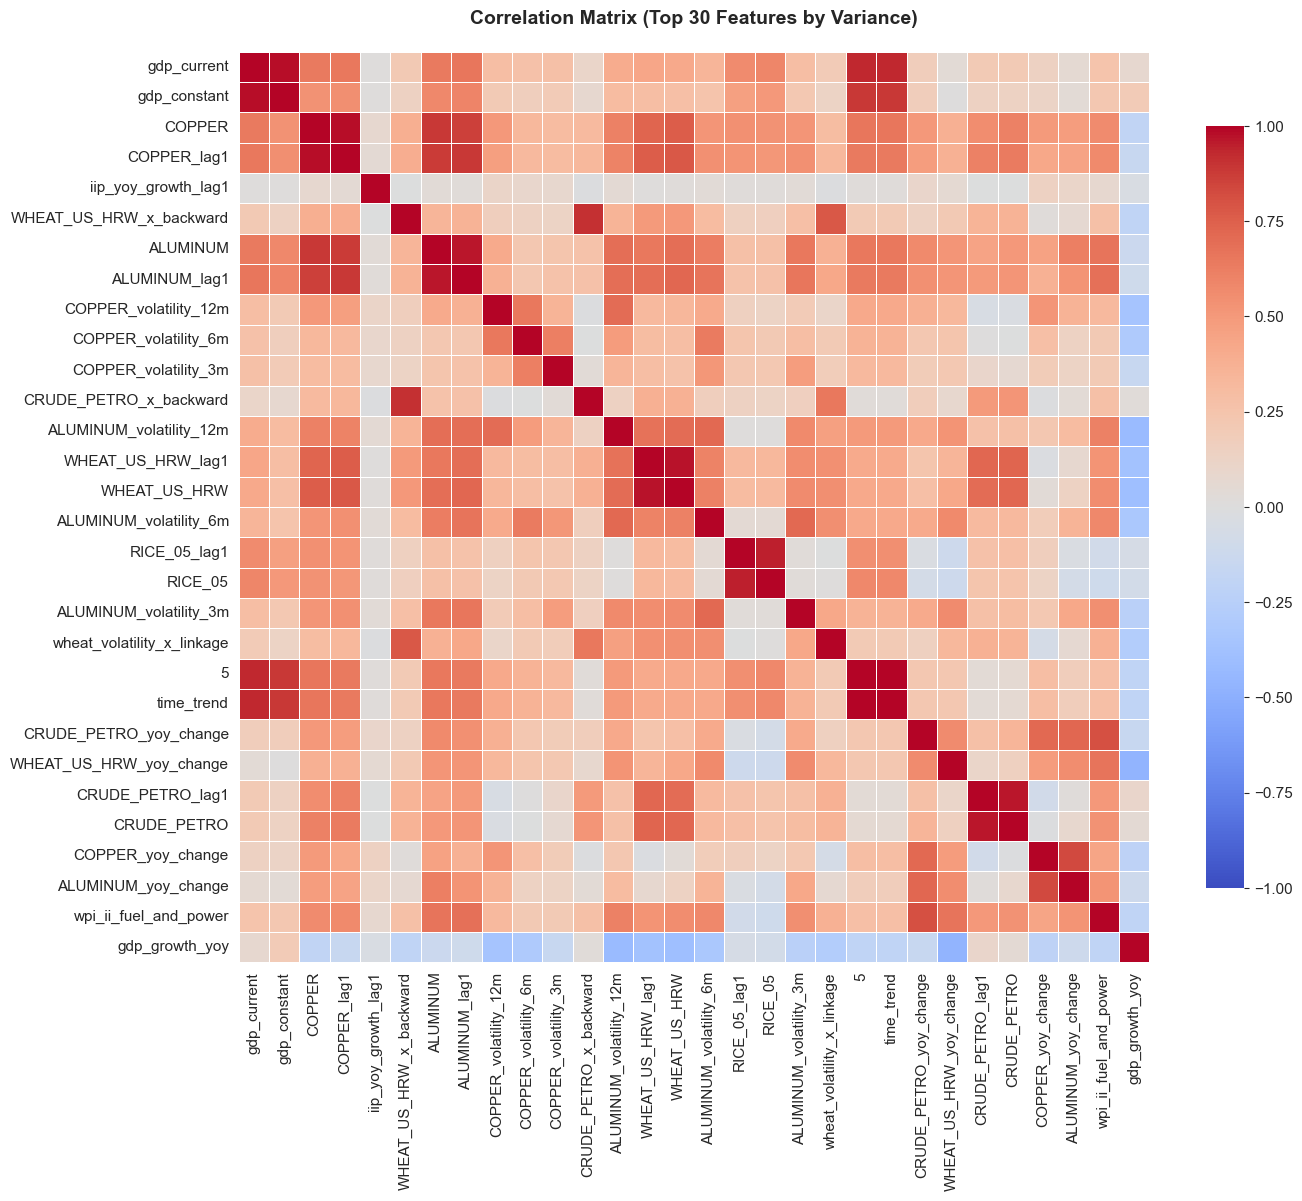

  ✓ Heatmap saved: ./task2_45/figures/correlation_matrix.png


In [24]:
# ============================================================================
# CORRELATION MATRIX & HEATMAP
# ============================================================================

print("\n[Calculating correlation matrix...]")

# Calculate correlation matrix
corr_matrix = X.corr()

# Find highly correlated features (|r| > 0.9)
high_corr_threshold = 0.9

# Get upper triangle
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > threshold
high_corr_pairs = []
for column in upper_triangle.columns:
    high_corr_features = upper_triangle[column][abs(upper_triangle[column]) > high_corr_threshold]
    for idx in high_corr_features.index:
        high_corr_pairs.append((column, idx, upper_triangle[column][idx]))

print(f"\n  Correlation threshold: |r| > {high_corr_threshold}")
print(f"  High correlation pairs found: {len(high_corr_pairs)}")

if len(high_corr_pairs) > 0:
    print(f"\n  Top 10 highly correlated pairs:")
    for i, (feat1, feat2, corr) in enumerate(sorted(high_corr_pairs, 
                                                     key=lambda x: abs(x[2]), 
                                                     reverse=True)[:10], 1):
        print(f"    {i:2d}. {feat1:30s} <-> {feat2:30s}: r = {corr:6.3f}")
    
    # Identify features to drop
    to_drop_corr = set()
    for feat1, feat2, corr in high_corr_pairs:
        # Keep feat1, drop feat2 (arbitrary choice)
        to_drop_corr.add(feat2)
    
    print(f"\n  Features to drop due to multicollinearity: {len(to_drop_corr)}")
else:
    to_drop_corr = set()
    print(f"\n  ✓ No highly correlated feature pairs found")

# Create correlation heatmap (for subset of features)
print(f"\n[Creating correlation heatmap...]")

# Select subset of features for visualization (top 30 by variance)
feature_variance = X.var().sort_values(ascending=False)
top_features = feature_variance.head(30).index.tolist()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(X[top_features].corr(), 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1,
            ax=ax)
ax.set_title('Correlation Matrix (Top 30 Features by Variance)', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(FIGURES_PATH + 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"  ✓ Heatmap saved: {FIGURES_PATH}correlation_matrix.png")

print("="*70)

In [25]:
# ============================================================================
# EPIC 2.5 - TASK 2.5.2: VARIANCE INFLATION FACTOR (VIF)
# ============================================================================

print("\n[Calculating Variance Inflation Factor...]")

# Remove highly correlated features first
X_reduced = X.drop(columns=list(to_drop_corr), errors='ignore')

print(f"  Features after correlation filter: {X_reduced.shape[1]}")
print(f"  Computing VIF (this may take a few minutes)...")

# Calculate VIF for subset of features (VIF is computationally expensive)
# Select most important features first (by correlation with target)

# Calculate correlation with target
target_corr = X_reduced.corrwith(y).abs().sort_values(ascending=False)

# Take top 50 features for VIF calculation
n_vif_features = min(50, len(X_reduced.columns))
vif_features = target_corr.head(n_vif_features).index.tolist()

print(f"  Calculating VIF for top {n_vif_features} features...")

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = vif_features

vif_values = []
for i, feature in enumerate(vif_features):
    if (i + 1) % 10 == 0:
        print(f"    Progress: {i+1}/{n_vif_features}")
    
    try:
        # Get feature index
        feature_idx = list(X_reduced[vif_features].columns).index(feature)
        vif = variance_inflation_factor(X_reduced[vif_features].values, feature_idx)
        vif_values.append(vif)
    except:
        vif_values.append(np.nan)

vif_data["VIF"] = vif_values

# Sort by VIF
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

print(f"\n  VIF Statistics:")
print(f"    Mean VIF: {vif_data['VIF'].mean():.2f}")
print(f"    Median VIF: {vif_data['VIF'].median():.2f}")
print(f"    Max VIF: {vif_data['VIF'].max():.2f}")

# Identify high VIF features (VIF > 10)
high_vif = vif_data[vif_data['VIF'] > 10]

print(f"\n  Features with VIF > 10: {len(high_vif)}")

if len(high_vif) > 0:
    print(f"\n  Top 10 highest VIF features:")
    print(high_vif.head(10).to_string(index=False))
    
    # Features to drop
    to_drop_vif = set(high_vif['Feature'].tolist())
    print(f"\n  Features to drop due to high VIF: {len(to_drop_vif)}")
else:
    to_drop_vif = set()
    print(f"\n  ✓ All VIF values < 10")

# Save VIF results
vif_data.to_csv(FEATURES_OUTPUT + 'vif_analysis.csv', index=False)
print(f"\n  ✓ VIF analysis saved: {FEATURES_OUTPUT}vif_analysis.csv")

print("="*70)


[Calculating Variance Inflation Factor...]
  Features after correlation filter: 106
  Computing VIF (this may take a few minutes)...
  Calculating VIF for top 50 features...
    Progress: 10/50
    Progress: 20/50
    Progress: 30/50
    Progress: 40/50
    Progress: 50/50

  VIF Statistics:
    Mean VIF: 1621834.29
    Median VIF: 10.48
    Max VIF: 20699790.29

  Features with VIF > 10: 27

  Top 10 highest VIF features:
                        Feature          VIF
                             q1 2.069979e+07
                             q2 2.013171e+07
                             q3 2.013065e+07
                             q4 2.012862e+07
                 financial_year 1.263744e+02
                  ALUMINUM_lag1 9.987213e+01
                    COPPER_lag1 9.740837e+01
                           Year 8.890793e+01
wpi_iii___manufactured_products 6.605537e+01
            ALUMINUM_yoy_change 4.819177e+01

  Features to drop due to high VIF: 27

  ✓ VIF analysis saved: ./task2_45/f


[Running Random Forest for feature importance...]
  Features after VIF/correlation filter: 79

  Training Random Forest...
  ✓ Random Forest trained
    R² score: 0.1159

  Top 20 Most Important Features:
   1. iip_yoy_growth_lag1                     : 0.2023
   2. ALUMINUM_vol_3m                         : 0.1193
   3. COPPER_vol_6m                           : 0.1001
   4. RICE_05_volatility_3m                   : 0.0958
   5. ALUMINUM_mom_change                     : 0.0772
   6. CRUDE_PETRO_volatility_6m               : 0.0670
   7. RICE_05_mom_change                      : 0.0589
   8. RICE_05_vol_6m                          : 0.0547
   9. COPPER_vol_3m                           : 0.0509
  10. CRUDE_PETRO_mom_change                  : 0.0374
  11. RICE_05_volatility_6m                   : 0.0314
  12. gdp_growth_yoy                          : 0.0180
  13. COPPER_mom_change                       : 0.0162
  14. COPPER_volatility_3m                    : 0.0115
  15. CRUDE_PETRO_volati

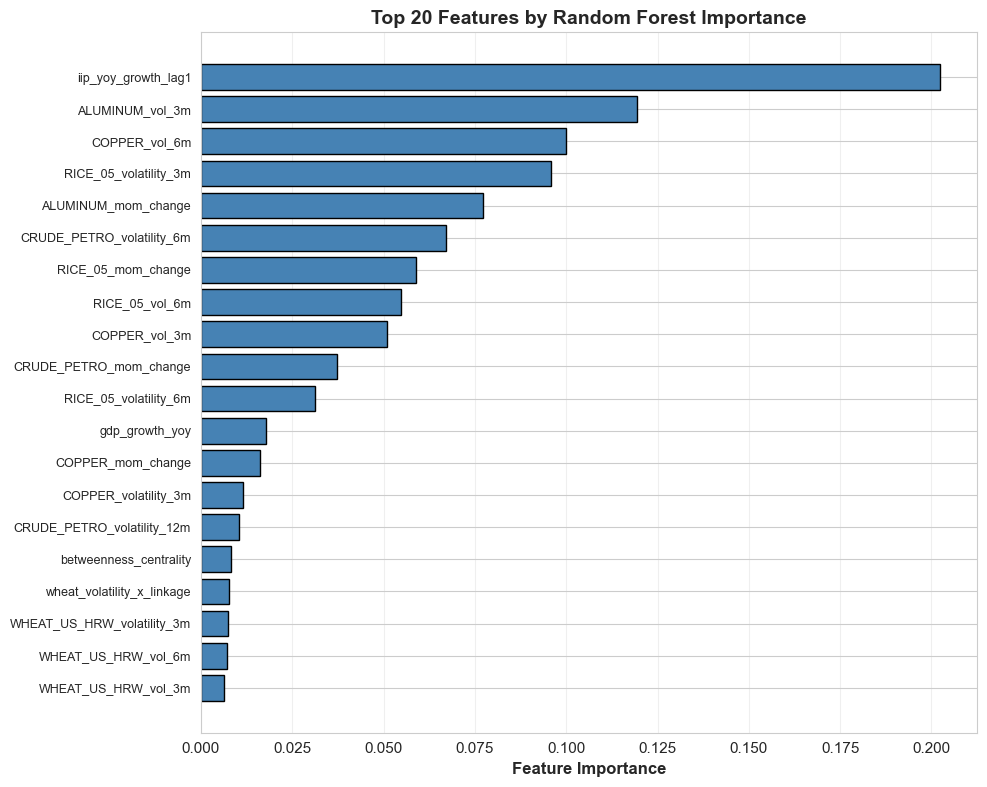


  ✓ Feature importance plot saved: ./task2_45/figures/feature_importance_rf.png
  ✓ Feature importance saved: ./task2_45/features/feature_importance_rf.csv


In [26]:
# ============================================================================
# EPIC 2.5 - TASK 2.5.3: RANDOM FOREST FEATURE IMPORTANCE
# ============================================================================

print("\n[Running Random Forest for feature importance...]")

# Combine features to drop
features_to_drop = to_drop_corr.union(to_drop_vif)

# Create cleaned feature set
X_clean = X.drop(columns=list(features_to_drop), errors='ignore')

print(f"  Features after VIF/correlation filter: {X_clean.shape[1]}")

# Train Random Forest
print(f"\n  Training Random Forest...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_clean, y)

print(f"  ✓ Random Forest trained")
print(f"    R² score: {rf_model.score(X_clean, y):.4f}")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print(f"\n  Top 20 Most Important Features:")
print("  " + "="*60)
for i, row in feature_importance.head(20).iterrows():
    print(f"  {i+1:2d}. {row['Feature']:40s}: {row['Importance']:.4f}")

# Select top 50 features
n_top_features = min(50, len(feature_importance))
top_features_rf = feature_importance.head(n_top_features)['Feature'].tolist()

print(f"\n  ✓ Selected top {n_top_features} features by importance")

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = feature_importance.head(20)
ax.barh(range(len(top_20)), top_20['Importance'], color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Feature'], fontsize=9)
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Features by Random Forest Importance', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_PATH + 'feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n  ✓ Feature importance plot saved: {FIGURES_PATH}feature_importance_rf.png")

# Save feature importance
feature_importance.to_csv(FEATURES_OUTPUT + 'feature_importance_rf.csv', index=False)
print(f"  ✓ Feature importance saved: {FEATURES_OUTPUT}feature_importance_rf.csv")

print("="*70)

In [27]:
# ============================================================================
# EPIC 2.5 - TASK 2.5.5: STANDARDIZE FEATURES
# ============================================================================

print("\n[Standardizing features to mean=0, std=1...]")

# Use top features from Random Forest
X_selected = X_clean[top_features_rf].copy()

print(f"  Features selected: {X_selected.shape[1]}")

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_selected.columns, index=X_selected.index)

print(f"\n  Before standardization:")
print(f"    Mean range: [{X_selected.mean().min():.2f}, {X_selected.mean().max():.2f}]")
print(f"    Std range:  [{X_selected.std().min():.2f}, {X_selected.std().max():.2f}]")

print(f"\n  After standardization:")
print(f"    Mean range: [{X_scaled_df.mean().min():.2e}, {X_scaled_df.mean().max():.2e}]")
print(f"    Std range:  [{X_scaled_df.std().min():.2f}, {X_scaled_df.std().max():.2f}]")

print(f"\n  ✓ Features standardized")

# Save scaler for later use
import pickle
scaler_path = FEATURES_OUTPUT + 'feature_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"  ✓ Scaler saved: {scaler_path}")

print("="*70)


[Standardizing features to mean=0, std=1...]
  Features selected: 50

  Before standardization:
    Mean range: [-0.18, 753.69]
    Std range:  [0.00, 1094.07]

  After standardization:
    Mean range: [-2.74e-15, 9.53e-16]
    Std range:  [1.00, 1.00]

  ✓ Features standardized
  ✓ Scaler saved: ./task2_45/features/feature_scaler.pkl



[Creating train-test split...]

  Train-Test Split:
  Set        Start        End          Observations    %
  ------------------------------------------------------------
  Train      2013-04      2020-12      2,134           66.9%
  Test       2021-01      2024-12      1,056           33.1%
  Total                                3,190           100.0%

  Target Variable Statistics:
  Set        Mean       Std        Min        Max
  --------------------------------------------------
  Train      0.50       16.71      -99.85     85.73     
  Test       117.63     1899.58    -37.53     54250.00  


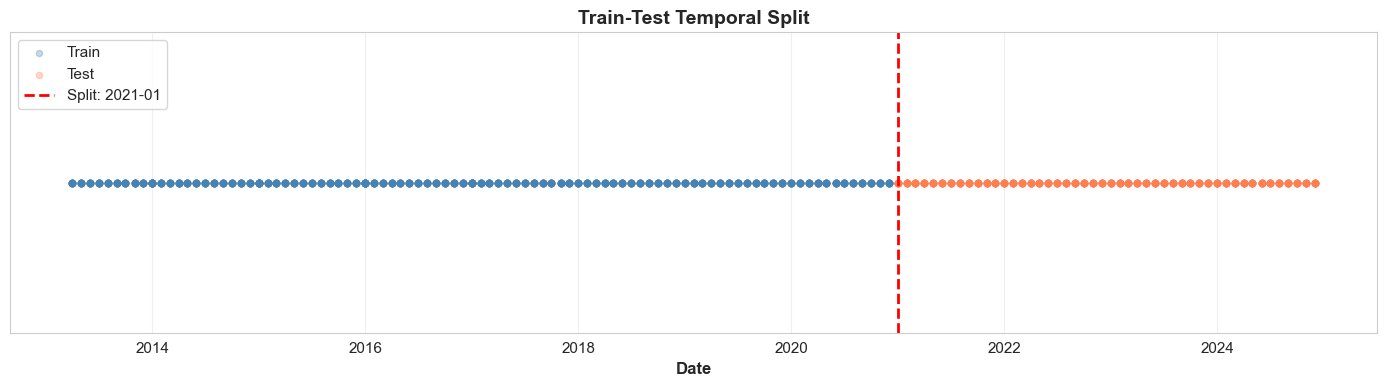


  ✓ Train-test split visualization saved: ./task2_45/figures/train_test_split.png


In [28]:
# ============================================================================
# EPIC 2.5 - TASK 2.5.6: TRAIN-TEST SPLIT (TEMPORAL)
# ============================================================================

print("\n[Creating train-test split...]")

# Get dates
dates = df_clean.loc[X_scaled_df.index, 'date']
sectors = df_clean.loc[X_scaled_df.index, 'sector_name']

# Split: 2013-2020 train (80%), 2021-2024 test (20%)
train_cutoff = pd.Timestamp('2021-01-01')

train_mask = dates < train_cutoff
test_mask = dates >= train_cutoff

# Create splits
X_train = X_scaled_df[train_mask]
X_test = X_scaled_df[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

dates_train = dates[train_mask]
dates_test = dates[test_mask]
sectors_train = sectors[train_mask]
sectors_test = sectors[test_mask]

print(f"\n  Train-Test Split:")
print(f"  {'Set':<10} {'Start':<12} {'End':<12} {'Observations':<15} {'%'}")
print(f"  " + "-"*60)
print(f"  {'Train':<10} {dates_train.min().strftime('%Y-%m'):<12} "
      f"{dates_train.max().strftime('%Y-%m'):<12} {len(X_train):<15,} "
      f"{len(X_train)/(len(X_train)+len(X_test))*100:.1f}%")
print(f"  {'Test':<10} {dates_test.min().strftime('%Y-%m'):<12} "
      f"{dates_test.max().strftime('%Y-%m'):<12} {len(X_test):<15,} "
      f"{len(X_test)/(len(X_train)+len(X_test))*100:.1f}%")
print(f"  {'Total':<10} {' ':<12} {' ':<12} {len(X_scaled_df):<15,} 100.0%")

# Check target distribution
print(f"\n  Target Variable Statistics:")
print(f"  {'Set':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max'}")
print(f"  " + "-"*50)
print(f"  {'Train':<10} {y_train.mean():<10.2f} {y_train.std():<10.2f} "
      f"{y_train.min():<10.2f} {y_train.max():<10.2f}")
print(f"  {'Test':<10} {y_test.mean():<10.2f} {y_test.std():<10.2f} "
      f"{y_test.min():<10.2f} {y_test.max():<10.2f}")

# Visualize train-test split
fig, ax = plt.subplots(figsize=(14, 4))

# Plot all dates
all_dates_unique = dates.sort_values().unique()
ax.scatter(dates_train, [1]*len(dates_train), alpha=0.3, s=20, 
          color='steelblue', label='Train')
ax.scatter(dates_test, [1]*len(dates_test), alpha=0.3, s=20, 
          color='coral', label='Test')

ax.axvline(x=train_cutoff, color='red', linestyle='--', linewidth=2, 
          label=f'Split: {train_cutoff.strftime("%Y-%m")}')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_title('Train-Test Temporal Split', fontsize=14, fontweight='bold')
ax.set_yticks([])
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH + 'train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n  ✓ Train-test split visualization saved: {FIGURES_PATH}train_test_split.png")

print("="*70)

In [29]:
# ============================================================================
# EPIC 2.5 - TASK 2.5.7: SAVE FINAL ML DATASETS
# ============================================================================

print("\n[Saving final ML datasets...]")

# Create train dataset
train_df = pd.DataFrame({
    'date': dates_train.values,
    'sector_name': sectors_train.values,
})

# Add features
for col in X_train.columns:
    train_df[col] = X_train[col].values

# Add target
train_df['target'] = y_train.values

# Create test dataset
test_df = pd.DataFrame({
    'date': dates_test.values,
    'sector_name': sectors_test.values,
})

# Add features
for col in X_test.columns:
    test_df[col] = X_test[col].values

# Add target
test_df['target'] = y_test.values

# Save
train_path = FEATURES_OUTPUT + 'train_data.csv'
test_path = FEATURES_OUTPUT + 'test_data.csv'

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"\n  ✓ Train dataset saved: {train_path}")
print(f"    Shape: {train_df.shape}")

print(f"\n  ✓ Test dataset saved: {test_path}")
print(f"    Shape: {test_df.shape}")

# Save feature list
feature_list_df = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Selected': [1 if feat in top_features_rf else 0 for feat in X_scaled_df.columns]
})

feature_list_path = FEATURES_OUTPUT + 'feature_list.csv'
feature_list_df.to_csv(feature_list_path, index=False)

print(f"\n  ✓ Feature list saved: {feature_list_path}")

# Save full feature-engineered + selected dataset (for Causal ML)
full_ml_df = pd.DataFrame({
    'date': dates.values,
    'sector_name': sectors.values,
})

for col in X_scaled_df.columns:
    full_ml_df[col] = X_scaled_df[col].values

full_ml_df['target'] = y.values

full_ml_path = FEATURES_OUTPUT + 'full_ml_dataset.csv'
full_ml_df.to_csv(full_ml_path, index=False)

print(f"\n  ✓ Full ML dataset saved: {full_ml_path}")
print(f"    Shape: {full_ml_df.shape}")

print("="*70)


[Saving final ML datasets...]

  ✓ Train dataset saved: ./task2_45/features/train_data.csv
    Shape: (2134, 53)

  ✓ Test dataset saved: ./task2_45/features/test_data.csv
    Shape: (1056, 53)

  ✓ Feature list saved: ./task2_45/features/feature_list.csv

  ✓ Full ML dataset saved: ./task2_45/features/full_ml_dataset.csv
    Shape: (3190, 53)


In [31]:
# ============================================================================
# EPIC 2.5 - TASK 2.5.4: PCA (OPTIONAL - FOR DIMENSIONALITY CHECK)
# ============================================================================

print("\n[PCA Analysis - Checking dimensionality...]")

# Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Run PCA
pca = PCA(random_state=42)
pca.fit(X_scaled)

# Calculate cumulative explained variance
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

print(f"\n  Total features: {X_clean.shape[1]}")
print(f"  Components for 95% variance: {n_components_95}")
print(f"  Dimensionality reduction: {(1 - n_components_95/X_clean.shape[1])*100:.1f}%")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Explained variance ratio
axes[0].bar(range(1, min(21, len(pca.explained_variance_ratio_)+1)), 
            pca.explained_variance_ratio_[:20],
            color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11, fontweight='bold')
axes[0].set_title('PCA: Explained Variance by Component (Top 20)', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Cumulative explained variance
axes[1].plot(range(1, len(cumsum_variance)+1), cumsum_variance, 
             linewidth=2, color='navy')
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
axes[1].axvline(x=n_components_95, color='red', linestyle='--', linewidth=2, 
                label=f'{n_components_95} components')
axes[1].set_xlabel('Number of Components', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11, fontweight='bold')
axes[1].set_title('PCA: Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig(FIGURES_PATH + 'pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n  ✓ PCA plot saved: {FIGURES_PATH}pca_analysis.png")

print(f"\n  [Decision: Use original features or PCA?]")
print(f"    Original features are interpretable and already reduced to ~{len(top_features_rf)}")
print(f"    → Recommend: Keep original features (no PCA transformation)")

print("="*70)


[PCA Analysis - Checking dimensionality...]


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [30]:
# ============================================================================
# FINAL SUMMARY & DOCUMENTATION
# ============================================================================

print("\n" + "="*70)
print("FEATURE ENGINEERING & SELECTION COMPLETE")
print("="*70)

# Summary statistics
print(f"\n[EPIC 2.4: FEATURE ENGINEERING]")
print(f"  ✓ Created {total_new_features} new features")
print(f"    - Lagged prices: {len(lagged_features)}")
print(f"    - Volatility: {len(volatility_features)}")
print(f"    - Shock indicators: {len(shock_features)}")
print(f"    - Exposure: {len(exposure_features)}")
print(f"    - Interactions: {len(interaction_features)}")
print(f"    - Temporal: {len(temporal_features)}")

print(f"\n[EPIC 2.5: FEATURE SELECTION]")
print(f"  ✓ Started with: {len(feature_cols)} features")
print(f"  ✓ Removed via correlation (|r| > 0.9): {len(to_drop_corr)}")
print(f"  ✓ Removed via VIF (> 10): {len(to_drop_vif)}")
print(f"  ✓ Selected by Random Forest: {len(top_features_rf)}")
print(f"  ✓ Final feature count: {len(top_features_rf)}")

print(f"\n[DATASETS CREATED]")
print(f"  ✓ Train set: {train_df.shape[0]:,} obs ({dates_train.min().year}-{dates_train.max().year})")
print(f"  ✓ Test set:  {test_df.shape[0]:,} obs ({dates_test.min().year}-{dates_test.max().year})")
print(f"  ✓ Features:  {len(top_features_rf)} selected features")

print(f"\n[FILES GENERATED]")
output_files = [
    ('master_ml_dataset.csv', 'Full feature-engineered dataset'),
    ('train_data.csv', 'Training set (2013-2020)'),
    ('test_data.csv', 'Test set (2021-2024)'),
    ('full_ml_dataset.csv', 'Selected features + target'),
    ('feature_list.csv', 'List of all features'),
    ('feature_importance_rf.csv', 'Random Forest importance scores'),
    ('vif_analysis.csv', 'VIF values'),
    ('feature_scaler.pkl', 'StandardScaler object'),
]

for filename, description in output_files:
    print(f"  • {filename:30s} - {description}")

print(f"\n[VISUALIZATIONS GENERATED]")
viz_files = [
    ('correlation_matrix.png', 'Feature correlation heatmap'),
    ('feature_importance_rf.png', 'Top 20 important features'),
    ('pca_analysis.png', 'PCA variance explained'),
    ('train_test_split.png', 'Temporal split visualization'),
]

for filename, description in viz_files:
    print(f"  • {filename:30s} - {description}")

# Create feature documentation
doc_text = f"""
FEATURE ENGINEERING & SELECTION DOCUMENTATION
==============================================

Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Project: Global Trade Shocks & Indian Manufacturing

OVERVIEW
--------
This document describes the feature engineering and selection process
for machine learning models predicting sectoral IIP growth.

FEATURE ENGINEERING (Epic 2.4)
-------------------------------
Total features created: {total_new_features}

1. Lagged Commodity Prices ({len(lagged_features)} features)
   - Commodities: Oil, Wheat, Rice, Copper, Aluminum
   - Lags: 1, 3, 6, 12 months

2. Price Volatility ({len(volatility_features)} features)
   - Rolling standard deviations
   - Windows: 3, 6, 12 months

3. Shock Indicators ({len(shock_features)} features)
   - Binary indicators for price changes > 2σ
   - Types: Positive, negative, absolute

4. Commodity Exposure ({len(exposure_features)} features)
   - Energy, food, metal exposure indicators
   - Weighted by backward linkage

5. Interaction Features ({len(interaction_features)} features)
   - Network × exposure
   - Volatility × centrality
   - Price × linkage

6. Temporal Features ({len(temporal_features)} features)
   - Year, month, quarter
   - Cyclical encoding (sin/cos)
   - Time trend

FEATURE SELECTION (Epic 2.5)
-----------------------------
Initial features: {len(feature_cols)}
Final features: {len(top_features_rf)}

Selection Process:
1. Correlation filter: Removed {len(to_drop_corr)} features (|r| > 0.9)
2. VIF filter: Removed {len(to_drop_vif)} features (VIF > 10)
3. Random Forest: Selected top {len(top_features_rf)} by importance
4. Standardization: Mean=0, Std=1

TRAIN-TEST SPLIT
----------------
Train: {len(X_train):,} observations ({dates_train.min().year}-{dates_train.max().year})
Test:  {len(X_test):,} observations ({dates_test.min().year}-{dates_test.max().year})
Split date: {train_cutoff.strftime('%Y-%m')}

TOP 20 FEATURES (by Random Forest importance)
----------------------------------------------
"""

for i, row in feature_importance.head(20).iterrows():
    doc_text += f"{i+1:2d}. {row['Feature']:40s} : {row['Importance']:.4f}\n"

doc_text += f"""

USAGE
-----
For ML models:
  - Load: train_data.csv, test_data.csv
  - Features: {len(top_features_rf)} columns (already standardized)
  - Target: 'target' column (iip_yoy_growth)

For Causal ML (Epic 2.6):
  - Load: full_ml_dataset.csv
  - Contains all {len(X_scaled_df):,} observations
  - Features already standardized
  
NOTES
-----
- Missing values handled via forward-fill + median imputation
- Temporal ordering preserved (no data leakage)
- Features standardized using sklearn.StandardScaler
- Scaler saved for inference: feature_scaler.pkl

NEXT STEPS
----------
1. Epic 2.6: Causal ML (DML, Causal Forest, Meta-learners)
2. Sprint 3: ML Models (LSTM, XGBoost, GNN)
3. Model evaluation and comparison

==============================================
"""

# Save documentation
doc_path = FEATURES_OUTPUT + 'FEATURE_DOCUMENTATION.txt'
with open(doc_path, 'w') as f:
    f.write(doc_text)

print(f"\n✓ Feature documentation saved: {doc_path}")

print("\n" + "="*70)
print("READY FOR EPIC 2.6 (CAUSAL ML) OR SPRINT 3 (ML MODELS)")
print("="*70)

print("\n✨ Feature Engineering & Selection notebook complete! ✨\n")


FEATURE ENGINEERING & SELECTION COMPLETE

[EPIC 2.4: FEATURE ENGINEERING]
  ✓ Created 72 new features
    - Lagged prices: 3
    - Volatility: 17
    - Shock indicators: 22
    - Exposure: 5
    - Interactions: 12
    - Temporal: 11

[EPIC 2.5: FEATURE SELECTION]
  ✓ Started with: 145 features
  ✓ Removed via correlation (|r| > 0.9): 39
  ✓ Removed via VIF (> 10): 27
  ✓ Selected by Random Forest: 50
  ✓ Final feature count: 50

[DATASETS CREATED]
  ✓ Train set: 2,134 obs (2013-2020)
  ✓ Test set:  1,056 obs (2021-2024)
  ✓ Features:  50 selected features

[FILES GENERATED]
  • master_ml_dataset.csv          - Full feature-engineered dataset
  • train_data.csv                 - Training set (2013-2020)
  • test_data.csv                  - Test set (2021-2024)
  • full_ml_dataset.csv            - Selected features + target
  • feature_list.csv               - List of all features
  • feature_importance_rf.csv      - Random Forest importance scores
  • vif_analysis.csv               - V

UnicodeEncodeError: 'charmap' codec can't encode character '\u03c3' in position 736: character maps to <undefined>

# Final Output